# Import des bibliothèques

In [41]:
import pandas as pd 
import pyarrow as pa
import pyarrow.dataset as ds
import numpy as np

# 1 - Importation des données météorologiques

Les données utilisées sont celles des stations météorologiques de MétéoFrance, téléchargées sous forme de fichier parquet depuis le site data.gouv. Plus particulièrement, il s'agit des données météorologiques issues des stations météorologiques parisienne, heure par heure, de 2020 à 2025. Nous ne conservons que les colonnes utiles à notre analyse : la température sous abri instantanée (T), la nébulosité totale (N, un indice pour la couverture nuageuse, 9 correspondant à un ciel invisible par brouillard ou autre phénomène météorologique similaire), la nébulosité de la couche nuageuse la plus basse (NBAS), l'insolation horaire (INS, durée pendant laquelle le rayonnement solaire est d'une intensité supérieure à 120W/m2) et l'intensité du rayonnement solaire (INFRAR en J/cm2)

In [42]:
dataset1 = ds.dataset("../data/2020-2023_75.parquet").scanner(columns=['NUM_POSTE','NOM_USUEL','AAAAMMJJHH','T','N','NBAS','INS','INFRAR'])
table1 = dataset1.to_table()
meteo_20202023_75 = table1.to_pandas()

In [43]:
dataset2 = ds.dataset("../data/2024-2025_75.parquet").scanner(columns=['NUM_POSTE','NOM_USUEL','AAAAMMJJHH','T','N','NBAS','INS','INFRAR'])
table2 = dataset2.to_table()
meteo_20242025_75 = table2.to_pandas()

# 2 - Exploration

In [44]:
print(meteo_20202023_75.info())
meteo_20202023_75

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209159 entries, 0 to 209158
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   NUM_POSTE   209159 non-null  Int64  
 1   NOM_USUEL   209159 non-null  object 
 2   AAAAMMJJHH  209159 non-null  Int64  
 3   T           209106 non-null  float64
 4   N           0 non-null       object 
 5   NBAS        0 non-null       object 
 6   INS         70000 non-null   Int64  
 7   INFRAR      0 non-null       object 
dtypes: Int64(3), float64(1), object(4)
memory usage: 13.4+ MB
None


,NUM_POSTE,NOM_USUEL,AAAAMMJJHH,T,N,NBAS,INS,INFRAR
0,75106001,LUXEMBOURG,2020010100,1.6,None,None,<NA>,None
1,75106001,LUXEMBOURG,2020010101,0.9,None,None,<NA>,None
2,75106001,LUXEMBOURG,2020010102,0.1,None,None,<NA>,None
3,75106001,LUXEMBOURG,2020010103,0.2,None,None,<NA>,None
4,75106001,LUXEMBOURG,2020010104,0.6,None,None,<NA>,None
...,...,...,...,...,...,...,...,...
209154,75116008,LONGCHAMP,2023123119,8.8,None,None,0,None
209155,75116008,LONGCHAMP,2023123120,8.2,None,None,0,None
209156,75116008,LONGCHAMP,2023123121,7.9,None,None,0,None
209157,75116008,LONGCHAMP,2023123122,8.0,None,None,0,None


# 3 - Nettoyage des données

On constate que certaines données ne sont pas collectées par les stations météo parisiennes : la nébulosité et l'intensité du rayonnement solaire. De plus de nombreux relevés apparaissent manquants. 
Par ailleurs la date n'est pas dans un format adapté.

In [45]:
meteo_20202023_75.drop(columns=['N','NBAS','INFRAR','INS'], inplace=True) #Suppression des colonnes vides
meteo_20202023_75['AAAAMMJJHH'] = pd.to_datetime(meteo_20202023_75['AAAAMMJJHH'], format='%Y%m%d%H') #Conversion en datetime
meteo_20202023_75.rename(columns={'AAAAMMJJHH':'Date'}, inplace=True) #Renommage de la colonne

In [46]:
meteo_20202023_75.head()

,NUM_POSTE,NOM_USUEL,Date,T
0,75106001,LUXEMBOURG,2020-01-01 00:00:00,1.6
1,75106001,LUXEMBOURG,2020-01-01 01:00:00,0.9
2,75106001,LUXEMBOURG,2020-01-01 02:00:00,0.1
3,75106001,LUXEMBOURG,2020-01-01 03:00:00,0.2
4,75106001,LUXEMBOURG,2020-01-01 04:00:00,0.6


On se retrouve avec un DataFrame contenant les températures mesurées toutes les heures de 2020 à 2023 pour les différentes stations météorologiques de Paris, avec un format de date approprié. On fait subir le même traitement aux données de la période 2024-2025.

In [47]:
meteo_20242025_75.drop(columns=['N','NBAS','INFRAR','INS'], inplace=True) #Suppression des colonnes vides
meteo_20242025_75['AAAAMMJJHH'] = pd.to_datetime(meteo_20242025_75['AAAAMMJJHH'], format='%Y%m%d%H') #Conversion en datetime
meteo_20242025_75.rename(columns={'AAAAMMJJHH':'Date'}, inplace=True) #Renommage de la colonne

Pour nous simplifier la tâche, nous fusionnons nos deux dataframes en un seul contenant toutes les données de température de 2020 à 2025 à Paris. 

In [48]:
meteo_20202025_75 = pd.concat([meteo_20202023_75, meteo_20242025_75], ignore_index=True)

A présent, regardons si il subsiste des données manquantes pour la température.

In [49]:
print(meteo_20202025_75["T"].isna().sum())
print(meteo_20202025_75["T"].size)

496
313009


Sur un total de 313009 données, 496 sont manquantes. Localisons les données manquantes, et tentons d'interpoler en distinguant les données manquantes isolées et les données manquantes groupées.

In [50]:
meteo_20202025_75 = meteo_20202025_75.sort_values(['NUM_POSTE','Date'])
results = []
for station, g in meteo_20202025_75.groupby('NUM_POSTE'):
    g = g.sort_values('Date')
    missing = g['T'].isna()
    if missing.sum() == 0:
        continue
    groups = (missing != missing.shift()).cumsum()
    missing_runs = (missing[missing].groupby(groups).size())
    intervals = (g.loc[missing, 'Date'].groupby(groups).agg(start="min", end="max", length="count"))
    summary = {
        "station": station,
        "total_missing_values": int(missing.sum()),
        "number_of_missing_sequences": int(len(missing_runs)),
        "isolated_sequences": int((missing_runs == 1).sum()),
        "grouped_sequences": int((missing_runs > 1).sum()),
        "max_consecutive_missing": int(missing_runs.max()),
        "mean_consecutive_missing": float(missing_runs.mean())
    }

    results.append((summary, intervals))
    
summary_df = pd.DataFrame([r[0] for r in results])
print(summary_df)

    station  total_missing_values  number_of_missing_sequences  \
0  75106001                     3                            3   
1  75107005                   450                           17   
2  75114001                     1                            1   
3  75114007                    14                            2   
4  75116008                    28                            8   

   isolated_sequences  grouped_sequences  max_consecutive_missing  \
0                   3                  0                        1   
1                   6                 11                      207   
2                   1                  0                        1   
3                   1                  1                       13   
4                   5                  3                       10   

   mean_consecutive_missing  
0                  1.000000  
1                 26.470588  
2                  1.000000  
3                  7.000000  
4                  3.500000  


La station météorologique de la Tour Eiffel (75107005) concentre 450 données manquantes sur 496, on s'autorise pour des raisons de sipmlicité à ne pas tenir compte de ces relevés et de concentrer le travail de reconstruction sur les autres stations météorologiques parisiennes qui présente peu de données manquantes.

In [51]:
meteo_20202025_75 = meteo_20202025_75[meteo_20202025_75["NUM_POSTE"] != 75107005]  # Suppression de la station avec trop de valeurs manquantes

In [54]:
meteo_202025_75 = meteo_20202025_75.pivot_table(index='Date', columns='NUM_POSTE', values='T',aggfunc='mean')
temp_cols = ["LUXEMBOURG","LARIBOISIERE","MONTSOURIS 1","MONTSOURIS 2","LONGCHAMP"]
meteo_202025_75.columns = temp_cols
meteo_202025_75 = meteo_202025_75.reset_index()
meteo_202025_75["n_nan"] = meteo_202025_75.isna().sum(axis=1)
meteo_202025_75["n_nan"].describe()

count    52373.000000
mean         0.000897
std          0.030575
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          2.000000
Name: n_nan, dtype: float64

On réalise après réorganisation du DataFrame que, dans le pire des cas, à un instant donné, il y a dans le pire des cas 2 données manquantes sur 5 stations, on remplacera ces données par la moyenne des autres températures mesurées à cette date. Compte tenu de la proximité spatiale des stations météorologiques parisiennes, de la grande similarité des données recueillies, ainsi que du faible nombre de données manquantes restantes (46), on remplacera les données manquantes par la moyenne des données disponibles au même instant.

In [55]:
mean = meteo_202025_75[temp_cols].mean()
count = meteo_202025_75[temp_cols].notna().sum(axis=1)
for col in temp_cols:
    meteo_202025_75[col] = meteo_202025_75[col].fillna((mean * count - meteo_202025_75[col]) / (count - 1))

On dispose à présent de données nettoyés et prêtes à l'emploi, que l'on sauvegarde dans un nouveau fichier parquet.

In [60]:
meteo_202025_75.to_parquet("../data/meteofrance_75_2020_2025_cleaned.parquet",engine="pyarrow", index=False)

# 4 - Visualisation des données

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns

Prenons à titre d'illustration la premiere journée du jeu de données, celle du 1er janvier 2020, et visualisons l'évolution des températures relevées par les différentes stations météorologiques parisiennes retenues au cours de la journée.

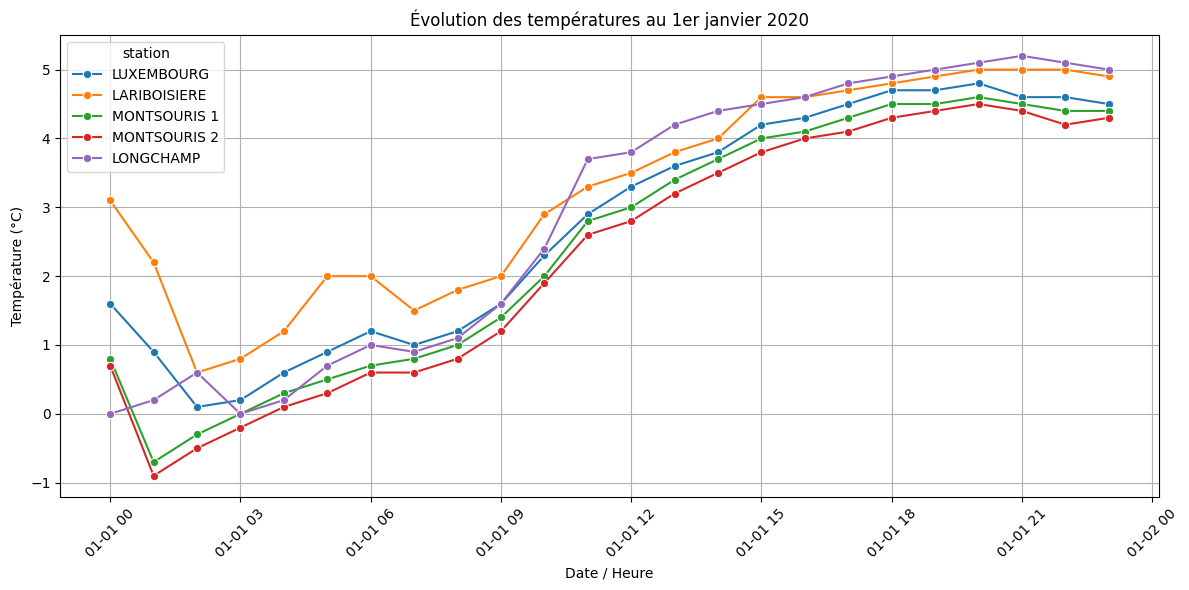

In [58]:
df_24h = meteo_202025_75.sort_values("Date").head(24)
df_long = df_24h.melt(id_vars="Date",value_vars=temp_cols,var_name="station",value_name="temperature")
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=df_long,
    x="Date",
    y="temperature",
    hue="station",
    marker="o"
)

plt.title("Évolution des températures au 1er janvier 2020")
plt.xlabel("Date / Heure")
plt.ylabel("Température (°C)")
plt.xticks(rotation=45)
plt.grid(True)

plt.tight_layout()
plt.show()